In [59]:
import pandas as pd
import glob ,os
import numpy as np
from scipy.fft import fft
from scipy.signal import welch
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.nn.utils import weight_norm
import warnings
warnings.filterwarnings("ignore")

In [ ]:

folder_path = 'air_pod_dataset'  


file_paths = glob.glob(os.path.join(folder_path, "*.csv"))

dataframes = []


for file_path in file_paths:
    # Extract the expression name from the filename
    expression_name = os.path.basename(file_path).split("_")[0]
    
    df = pd.read_csv(file_path)
    
    df['expression'] = expression_name
    
    dataframes.append(df)

In [61]:
for dfs in dataframes:
    print(dfs.shape)

(313, 18)
(424, 18)
(364, 18)
(486, 18)
(536, 18)
(350, 18)
(951, 18)
(1123, 18)
(1235, 18)
(1042, 18)
(860, 18)
(415, 18)
(536, 18)
(355, 18)
(177, 18)
(315, 18)
(889, 18)
(64, 18)
(99, 18)
(41, 18)
(88, 18)
(418, 18)
(387, 18)
(184, 18)
(332, 18)
(272, 18)
(55, 18)
(146, 18)
(184, 18)
(193, 18)
(200, 18)
(231, 18)


In [62]:
dataframes[20]

,Timestamp,QuaternionX,QuaternionY,QuaternionZ,QuaternionW,AttitudePitch,AttitudeRoll,AttitudeYaw,GravitationalAccelerationX,GravitationalAccelerationY,GravitationalAccelerationZ,AccelerationX,AccelerationY,AccelerationZ,RotationX,RotationY,RotationZ,expression
0,1.729583e+09,-0.053764,-0.110411,0.145270,0.981741,-0.138082,-0.204525,0.279620,-0.201169,0.137644,-0.969838,0.003004,-0.009427,0.001385,0.023560,-0.028339,0.013740,smile
1,1.729583e+09,-0.052842,-0.110813,0.145484,0.981714,-0.136418,-0.205539,0.280155,-0.202199,0.135996,-0.969856,0.003542,-0.008021,0.001250,0.047856,-0.026711,0.005471,smile
2,1.729583e+09,-0.051379,-0.111289,0.145653,0.981713,-0.133697,-0.206845,0.280686,-0.203540,0.133299,-0.969950,0.001276,-0.007370,-0.003529,0.072533,-0.049989,-0.000431,smile
3,1.729583e+09,-0.049695,-0.112126,0.145672,0.981701,-0.130610,-0.208954,0.280909,-0.205670,0.130239,-0.969916,0.004222,-0.004407,-0.000899,0.069313,-0.058559,-0.019896,smile
4,1.729583e+09,-0.047997,-0.113015,0.145402,0.981724,-0.127449,-0.211209,0.280553,-0.207942,0.127105,-0.969848,0.001779,-0.005223,-0.004262,0.061024,-0.067627,-0.027767,smile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1.729583e+09,-0.117414,-0.090297,0.155636,0.976646,-0.260383,-0.145217,0.297011,-0.139830,0.257450,-0.956121,-0.004379,0.001604,0.000089,-0.012531,0.019161,0.018721,smile
84,1.729583e+09,-0.117763,-0.089939,0.155895,0.976596,-0.261009,-0.144323,0.297616,-0.138952,0.258056,-0.956086,-0.002172,0.002670,0.002015,-0.013186,0.018070,0.009403,smile
85,1.729583e+09,-0.117981,-0.089627,0.155996,0.976582,-0.261366,-0.143601,0.297892,-0.138248,0.258400,-0.956095,-0.000421,0.001275,0.004016,-0.001163,0.015785,0.002853,smile
86,1.729583e+09,-0.118006,-0.089320,0.155937,0.976617,-0.261313,-0.142985,0.297847,-0.137660,0.258349,-0.956193,0.002577,0.003574,0.002321,0.000015,0.015246,-0.007502,smile


In [ ]:

# Function for band-pass filtering
def band_pass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimate_variance):
        self.process_variance = process_variance  # Process variance
        self.measurement_variance = measurement_variance  # Measurement variance
        self.estimate_variance = estimate_variance  # Estimate variance (initial)
        self.posteri_estimate = 0.0  # Initial estimate
        self.posteri_error_estimate = 1.0  # Initial estimate error

    def filter(self, measurement):
        
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        
        blending_factor = priori_error_estimate / (priori_error_estimate + self.measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

        return self.posteri_estimate


# Apply band-pass filter
lowcut, highcut, fs = 0.1, 5, 44  # Lowcut and highcut frequency, sampling rate


filtered_dataframes = []


# List to store filtered DataFrames
for df in dataframes:  
  
    filtered_df = df.copy()
    for col in df.columns:
      
        if col != 'expression' and col != 'Timestamp' and np.issubdtype(df[col].dtype, np.number):
            # Apply band-pass filter
            band_passed_data = band_pass_filter(df[col], lowcut, highcut, fs)
            
            # Apply Kalman filter to the band-pass filtered data
            kalman_filter = KalmanFilter(process_variance=1e-5, measurement_variance=1e-3, estimate_variance=1)
            filtered_data = [kalman_filter.filter(x) for x in band_passed_data]
            
           
            filtered_df[col] = filtered_data
    
 
    filtered_dataframes.append(filtered_df)

print(filtered_dataframes[0].head())


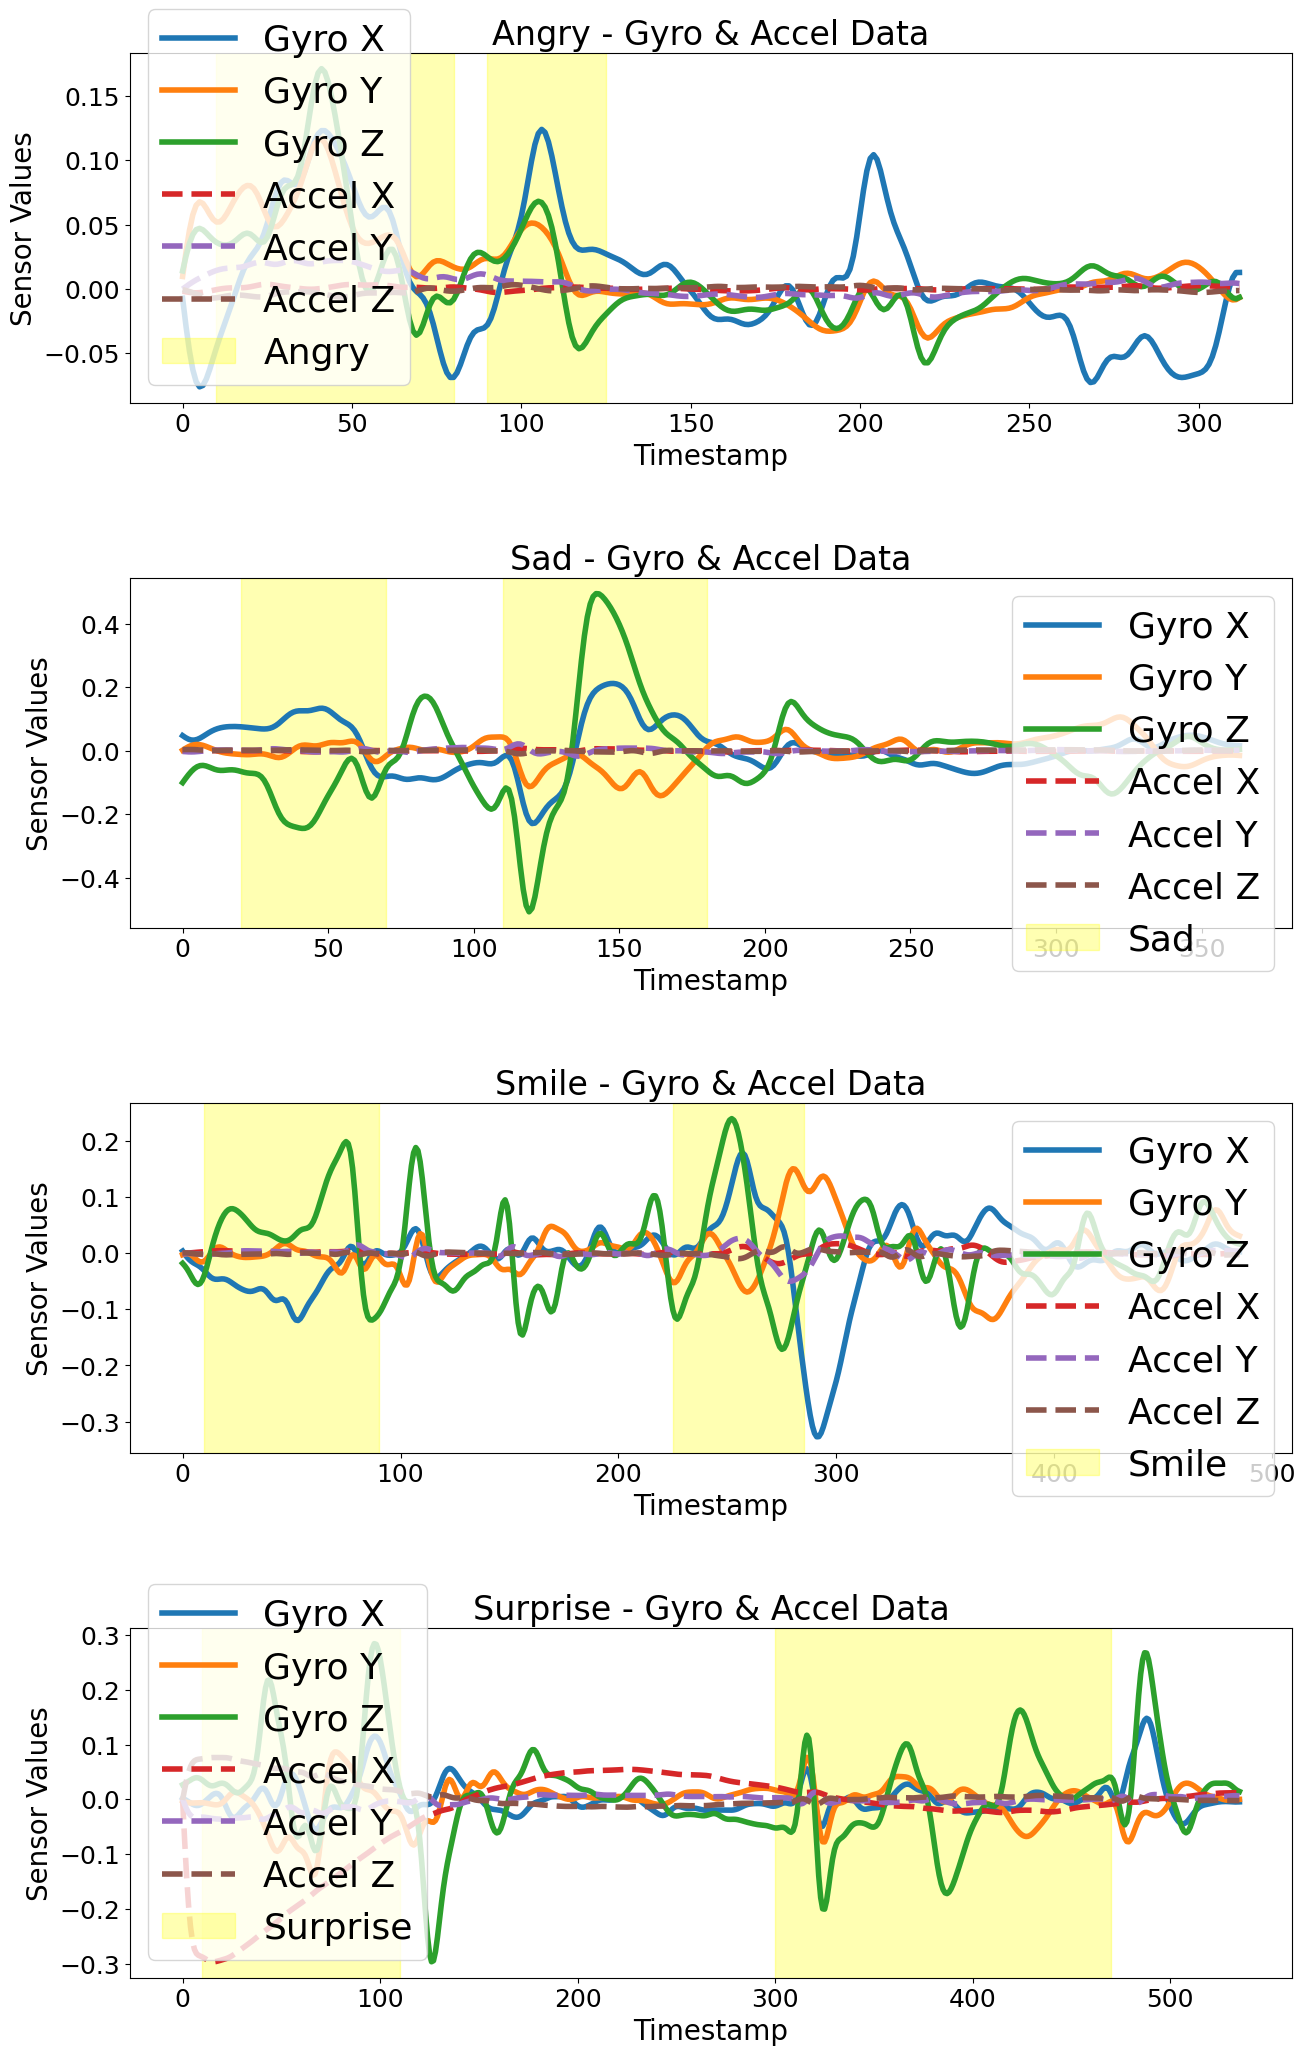

In [ ]:

# Define expressions to plot
expressions_to_plot = ['Angry', 'Sad', 'Smile', 'Surprise']


fig, axes = plt.subplots(4, 1, figsize=(15, 25), gridspec_kw={'hspace': 0.5})

axes[0].plot(filtered_dataframes[0]['RotationX'], label='Gyro X', linewidth=4)
axes[0].plot(filtered_dataframes[0]['RotationY'], label='Gyro Y', linewidth=4)
axes[0].plot(filtered_dataframes[0]['RotationZ'], label='Gyro Z', linewidth=4)
axes[0].plot(filtered_dataframes[0]['AccelerationX'], label='Accel X', linewidth=4, linestyle='--')
axes[0].plot(filtered_dataframes[0]['AccelerationY'], label='Accel Y', linewidth=4, linestyle='--')
axes[0].plot(filtered_dataframes[0]['AccelerationZ'], label='Accel Z', linewidth=4, linestyle='--')
axes[0].axvspan(10, 80, color='yellow', alpha=0.3, label=expressions_to_plot[0])
axes[0].axvspan(90, 125, color='yellow', alpha=0.3)
axes[0].set_title(f'{expressions_to_plot[0]} - Gyro & Accel Data', fontsize=24)
axes[0].set_xlabel('Timestamp', fontsize=20)
axes[0].set_ylabel('Sensor Values', fontsize=20)
axes[0].legend(fontsize=26)
axes[0].tick_params(axis='both', which='major', labelsize=18)

# Plot for Sad
axes[1].plot(filtered_dataframes[2]['RotationX'], label='Gyro X', linewidth=4)
axes[1].plot(filtered_dataframes[2]['RotationY'], label='Gyro Y', linewidth=4)
axes[1].plot(filtered_dataframes[2]['RotationZ'], label='Gyro Z', linewidth=4)
axes[1].plot(filtered_dataframes[2]['AccelerationX'], label='Accel X', linewidth=4, linestyle='--')
axes[1].plot(filtered_dataframes[2]['AccelerationY'], label='Accel Y', linewidth=4, linestyle='--')
axes[1].plot(filtered_dataframes[2]['AccelerationZ'], label='Accel Z', linewidth=4, linestyle='--')
axes[1].axvspan(20, 70, color='yellow', alpha=0.3, label=expressions_to_plot[1])
axes[1].axvspan(110, 180, color='yellow', alpha=0.3)
axes[1].set_title(f'{expressions_to_plot[1]} - Gyro & Accel Data', fontsize=24)
axes[1].set_xlabel('Timestamp', fontsize=20)
axes[1].set_ylabel('Sensor Values', fontsize=20)
axes[1].legend(fontsize=26)
axes[1].tick_params(axis='both', which='major', labelsize=18)

# Plot for Smile
axes[2].plot(filtered_dataframes[3]['RotationX'], label='Gyro X', linewidth=4)
axes[2].plot(filtered_dataframes[3]['RotationY'], label='Gyro Y', linewidth=4)
axes[2].plot(filtered_dataframes[3]['RotationZ'], label='Gyro Z', linewidth=4)
axes[2].plot(filtered_dataframes[3]['AccelerationX'], label='Accel X', linewidth=4, linestyle='--')
axes[2].plot(filtered_dataframes[3]['AccelerationY'], label='Accel Y', linewidth=4, linestyle='--')
axes[2].plot(filtered_dataframes[3]['AccelerationZ'], label='Accel Z', linewidth=4, linestyle='--')
axes[2].axvspan(10, 90, color='yellow', alpha=0.3, label=expressions_to_plot[2])
axes[2].axvspan(225, 285, color='yellow', alpha=0.3)
axes[2].set_title(f'{expressions_to_plot[2]} - Gyro & Accel Data', fontsize=24)
axes[2].set_xlabel('Timestamp', fontsize=20)
axes[2].set_ylabel('Sensor Values', fontsize=20)
axes[2].legend(fontsize=26)
axes[2].tick_params(axis='both', which='major', labelsize=18)

# Plot for Surprise
axes[3].plot(filtered_dataframes[4]['RotationX'], label='Gyro X', linewidth=4)
axes[3].plot(filtered_dataframes[4]['RotationY'], label='Gyro Y', linewidth=4)
axes[3].plot(filtered_dataframes[4]['RotationZ'], label='Gyro Z', linewidth=4)
axes[3].plot(filtered_dataframes[4]['AccelerationX'], label='Accel X', linewidth=4, linestyle='--')
axes[3].plot(filtered_dataframes[4]['AccelerationY'], label='Accel Y', linewidth=4, linestyle='--')
axes[3].plot(filtered_dataframes[4]['AccelerationZ'], label='Accel Z', linewidth=4, linestyle='--')
axes[3].axvspan(10, 110, color='yellow', alpha=0.3, label=expressions_to_plot[3])
axes[3].axvspan(300, 470, color='yellow', alpha=0.3)
axes[3].set_title(f'{expressions_to_plot[3]} - Gyro & Accel Data', fontsize=24)
axes[3].set_xlabel('Timestamp', fontsize=20)
axes[3].set_ylabel('Sensor Values', fontsize=20)
axes[3].legend(fontsize=26)
axes[3].tick_params(axis='both', which='major', labelsize=18)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

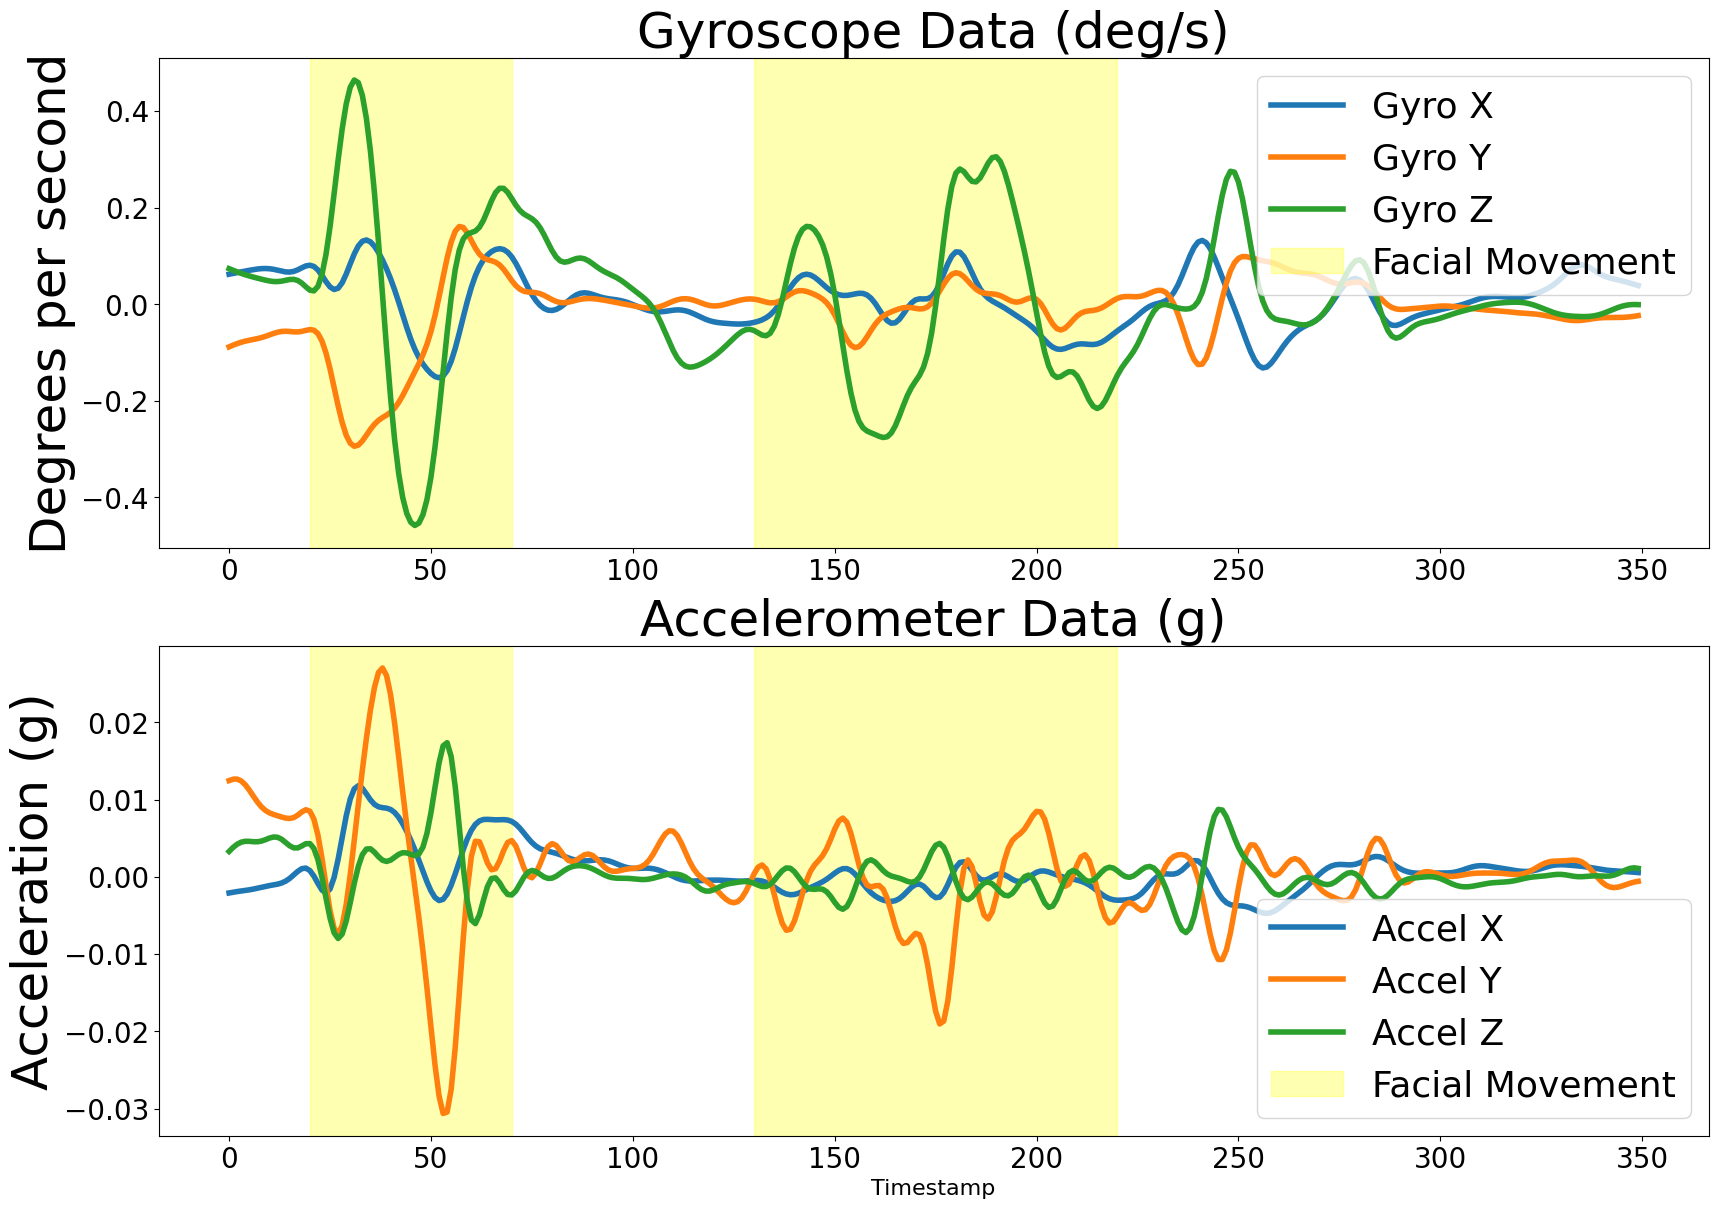

In [ ]:


# Set the figure size
plt.figure(figsize=(20, 14))

# Plot gyroscope data (X, Y, Z)
plt.subplot(2, 1, 1)
plt.plot(filtered_dataframes[5]['RotationX'], label='Gyro X', linewidth=4)
plt.plot(filtered_dataframes[5]['RotationY'], label='Gyro Y', linewidth=4)
plt.plot(filtered_dataframes[5]['RotationZ'], label='Gyro Z', linewidth=4)

start_time, end_time = 20, 70 
plt.axvspan(start_time, end_time, color='yellow', alpha=0.3, label='Facial Movement')
plt.axvspan(130, 220, color='yellow', alpha=0.3)
plt.annotate('Event of Interest', xy=(250, 50), xytext=(280, 100), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20)
plt.title('Gyroscope Data (deg/s)', fontsize=36)
plt.ylabel('Degrees per second', fontsize=36)
plt.legend(fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.subplot(2, 1, 2)
plt.plot(filtered_dataframes[5]['AccelerationX'], label='Accel X', linewidth=4)
plt.plot(filtered_dataframes[5]['AccelerationY'], label='Accel Y', linewidth=4)
plt.plot(filtered_dataframes[5]['AccelerationZ'], label='Accel Z', linewidth=4)

start_time, end_time = 20, 70
plt.axvspan(start_time, end_time, color='yellow', alpha=0.3, label='Facial Movement')
plt.axvspan(130, 220, color='yellow', alpha=0.3)
plt.annotate('Event of Interest', xy=(250, 0.5), xytext=(280, 1.0), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=16)

plt.title('Accelerometer Data (g)', fontsize=36)
plt.ylabel('Acceleration (g)', fontsize=36)
plt.xlabel('Timestamp', fontsize=16)
plt.legend(fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.show()

In [ ]:
# Define window and step sizes
window_size = 40  # Number of rows per sequence
step_size = 5    # Shift of window (50% overlap)

# Placeholder for all sequences
all_sequences = []


for df in filtered_dataframes:
    # Ensure that the DataFrame has at least 'window_size' rows
    if len(df) >= window_size:
      
        for start in range(0, len(df) - window_size + 1, step_size):
            # Extract the windowed data
            window_df = df.iloc[start:start + window_size]
            
           
            window_values = window_df  
            
            
            all_sequences.append(window_values)

    else:
        print(" df discaded..." )

print(len(all_sequences))


2417


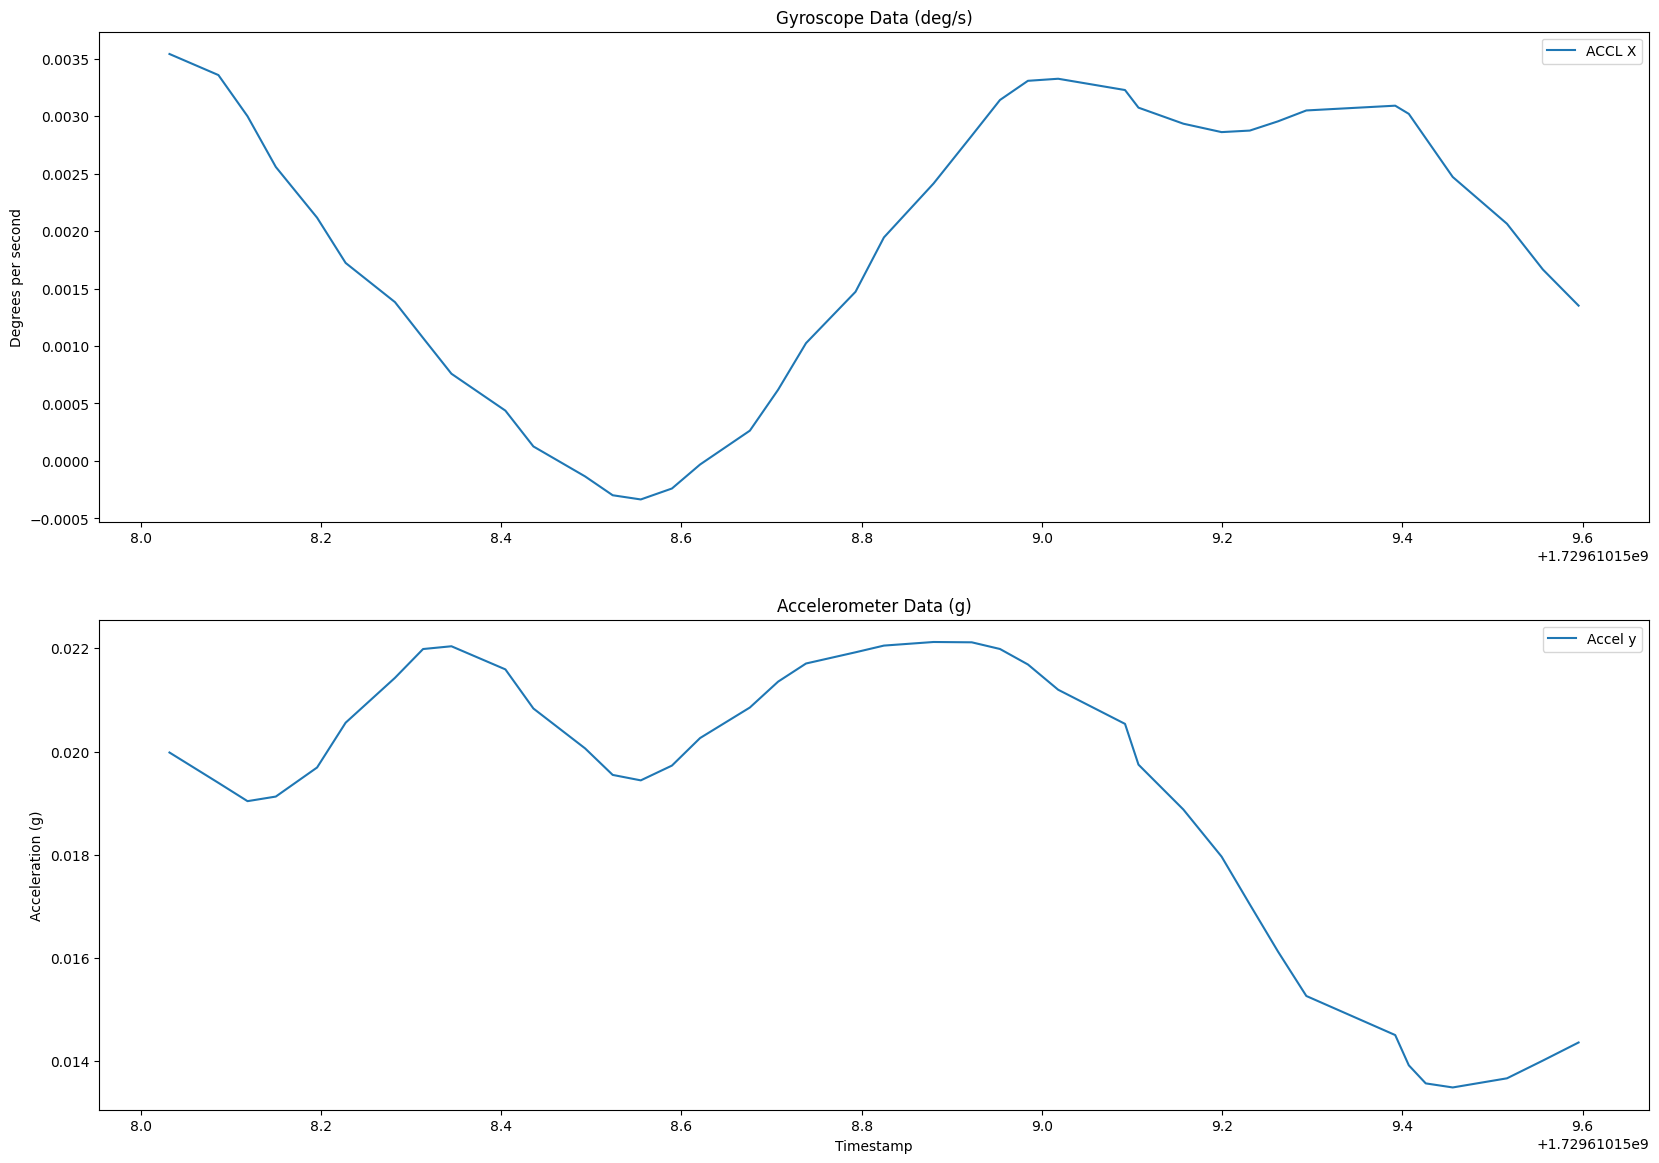

In [ ]:
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(all_sequences[5]['Timestamp'], all_sequences[5]['AccelerationX'], label='ACCL X')

plt.title('Gyroscope Data (deg/s)')
plt.ylabel('Degrees per second')
plt.legend()

# Plot accelerometer data
plt.subplot(2, 1, 2)
plt.plot(all_sequences[5]['Timestamp'], all_sequences[5]['AccelerationY'], label='Accel y')

plt.title('Accelerometer Data (g)')
plt.ylabel('Acceleration (g)')
plt.xlabel('Timestamp')
plt.legend()

plt.show()

In [11]:
len(all_sequences[0])

40

In [ ]:
# Function to extract frequency-domain features, including PSD


def extract_frequency_features_batch_tensor(batch_tensor, fs=44):  # fs = sampling rate
    batch_size, sequence_length, num_features = batch_tensor.shape

    features_per_column = 5
    batch_features = np.zeros((batch_size, num_features * features_per_column))
    
    for i in range(batch_size):
        window_features = []
        
        for j in range(num_features):
            # Extract the time series data for the current feature column
            column_data = batch_tensor[i, :, j].cpu().numpy()  
            
            # Perform FFT and calculate magnitudes
            fft_vals = fft(column_data)
            fft_magnitudes = np.abs(fft_vals)
            
            # Calculate frequency features
            dominant_freq = np.argmax(fft_magnitudes[1:]) + 1
            energy = np.sum(fft_magnitudes ** 2) / len(fft_magnitudes)
            
            # Calculate Power Spectral Density (PSD) using Welch's method
            freqs, psd = welch(column_data, fs=fs)
            psd_mean = np.mean(psd)
            psd_std = np.std(psd)
            psd_max = np.max(psd)
            
            # Append calculated features for this column
            window_features.extend([dominant_freq, energy, psd_mean, psd_std, psd_max])
        
        # Store the features for the current window
        batch_features[i] = window_features
    
    # Convert to tensor
    return torch.tensor(batch_features, dtype=torch.float32)

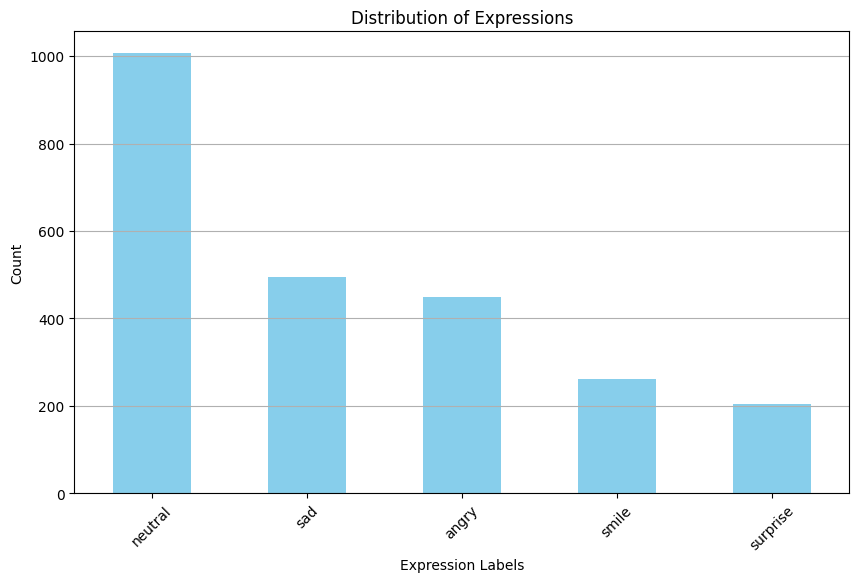

In [54]:
# Count the occurrences of each expression
expression_counts = frequency_features_df['expression'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
expression_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Expressions')
plt.xlabel('Expression Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:


# TCN building blocks: Temporal Block and Temporal ConvNet

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, 3,
                                           stride=stride, padding=padding, dilation=dilation))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, 3,
                                           stride=stride, padding=padding, dilation=dilation))
        self.net = nn.Sequential(self.conv1, self.relu, self.dropout,
                                 self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        
        res = x if self.downsample is None else self.downsample(x)
        
        return self.relu(out + res)
        


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Adapting the TCN model to your data specifications
class FeatureExtractorTCN(nn.Module):
    def __init__(self, input_size=16, sequence_length=40, hidden_channels=[64, 128, 256], kernel_size=3, dropout=0.2 , num_classes = 5):
        super(FeatureExtractorTCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, hidden_channels, kernel_size, dropout)
        self.global_pooling = nn.AdaptiveAvgPool1d(1)  # Global pooling to summarize features

        self.classifier = nn.Sequential(
            nn.Linear(256 + 80, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        input = x.permute(0,2,1)
        input = self.tcn(input)  # Pass through TCN
        input = self.global_pooling(input)  
        freq_features = extract_frequency_features_batch_tensor(x)
        input = input.squeeze(-1)
        input = torch.cat((input , freq_features),  1)
        input = self.classifier(input)
        #print((input.shape , x.shape) ,freq_features.shape )
        return input  





In [ ]:
def prepare_dataframes(dataframes):
    labels = [df['expression'].iloc[0] for df in dataframes] 
    dataframes = [df.drop(columns=['Timestamp', 'expression']) for df in dataframes]

    # Convert each DataFrame to numeric to ensure there are no issues with dtype
    dataframes = [df.apply(pd.to_numeric, errors='coerce').fillna(0) for df in dataframes]
    

    data_array = np.stack([df.values for df in dataframes], axis=0)
    
    labels_cat = pd.Categorical(labels)
    label_tensor = labels_cat.codes
    print(labels_cat , label_tensor)
    
    return data_array, label_tensor

# Example usage
data_tensor, label_tensor = prepare_dataframes(all_sequences)


print("Data tensor shape:", data_tensor.shape)    
print("Label tensor shape:", label_tensor.shape)


['angry', 'angry', 'angry', 'angry', 'angry', ..., 'surprise', 'surprise', 'surprise', 'surprise', 'surprise']
Length: 2417
Categories (5, object): ['angry', 'neutral', 'sad', 'smile', 'surprise'] [0 0 0 ... 4 4 4]
Data tensor shape: (2417, 40, 16)
Label tensor shape: (2417,)


In [ ]:

from torch.utils.data import DataLoader, Dataset, random_split

# Define a custom dataset class
class IMUDataset(Dataset):
    def __init__(self, data, labels):

        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # adjust dtype if labels are floats or integers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = IMUDataset(data_tensor, label_tensor)

# Split dataset into 80% training and 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset shapes for confirmation
for data, label in train_loader:
    print("Batch data shape:", data.shape)    # Should be [32, 16, 40]
    print("Batch label shape:", label.shape)  # Should be [32]
    break

Batch data shape: torch.Size([32, 40, 16])
Batch label shape: torch.Size([32])


In [71]:
model = FeatureExtractorTCN(input_size=16, sequence_length=40, hidden_channels=[64, 128, 256] , kernel_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F

train_losses = []
test_accuracies = []
all_probs = []  # List to store probabilities

def test_model_with_probs(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    probs = [] 
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            probabilities = F.softmax(outputs, dim=1) 
            probs.append(probabilities)  
            
        
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, torch.cat(probs)  # Concatenate all probabilities across batches


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Lists to store loss and accuracy values for plotting
train_losses = []
test_accuracies = []
all_probs = []


# Training loop
for epoch in range(60): 
    model.train()
    running_loss = 0.0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        loss = criterion(outputs, batch_labels)
       
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss) 
    
    # Print training loss
    print(f"Epoch [{epoch + 1}/20], Loss: {avg_train_loss:.4f}")

    test_accuracy, epoch_probs = test_model_with_probs(model, test_loader)
    test_accuracies.append(test_accuracy)  # Store accuracy for plotting
    all_probs.append(epoch_probs)




Epoch [1/20], Loss: 1.4498
Epoch [2/20], Loss: 1.3757
Epoch [3/20], Loss: 1.2867
Epoch [4/20], Loss: 1.2237
Epoch [5/20], Loss: 1.1519
Epoch [6/20], Loss: 1.0580
Epoch [7/20], Loss: 1.0119
Epoch [8/20], Loss: 0.9472
Epoch [9/20], Loss: 0.9101
Epoch [10/20], Loss: 0.8857
Epoch [11/20], Loss: 0.8390
Epoch [12/20], Loss: 0.8365
Epoch [13/20], Loss: 0.7799
Epoch [14/20], Loss: 0.7734
Epoch [15/20], Loss: 0.7386
Epoch [16/20], Loss: 0.8107
Epoch [17/20], Loss: 0.7097
Epoch [18/20], Loss: 0.6767
Epoch [19/20], Loss: 0.6593
Epoch [20/20], Loss: 0.6905
Epoch [21/20], Loss: 0.6235
Epoch [22/20], Loss: 0.6259
Epoch [23/20], Loss: 0.5808
Epoch [24/20], Loss: 0.6625
Epoch [25/20], Loss: 0.5642
Epoch [26/20], Loss: 0.5711
Epoch [27/20], Loss: 0.5673
Epoch [28/20], Loss: 0.5654
Epoch [29/20], Loss: 0.5243
Epoch [30/20], Loss: 0.5092
Epoch [31/20], Loss: 0.4758
Epoch [32/20], Loss: 0.4853
Epoch [33/20], Loss: 0.5040
Epoch [34/20], Loss: 0.4387
Epoch [35/20], Loss: 0.4812
Epoch [36/20], Loss: 0.4299
E

In [ ]:
from scipy.stats import norm
import numpy as np

# Bayesian Priors: Mean and standard deviation for each expression
priors = {
    "neutral": {"arousal": (0.2, 0.1), "valence": (0.0, 0.1)},
    "smile": {"arousal": (0.5, 0.1), "valence": (0.8, 0.1)},
    "surprise": {"arousal": (1.0, 0.1), "valence": (0.0, 0.1)},
    "sad": {"arousal": (0.2, 0.1), "valence": (-0.8, 0.1)},
    "anger": {"arousal": (0.9, 0.1), "valence": (-0.7, 0.1)},
}

# Define class labels
class_labels = ["neutral", "smile", "surprise", "sad", "anger"]


def compute_arousal_valence(probabilities, priors):
    arousal, valence = 0, 0
    arousal_variance, valence_variance = 0, 0
    
    for i, prob in enumerate(probabilities):
        expr = class_labels[i]
        a_mean, a_std = priors[expr]["arousal"]
        v_mean, v_std = priors[expr]["valence"]
        
        # Weighted sum of means (posterior expected value)
        arousal += prob * a_mean
        valence += prob * v_mean
        
        # Combine variances
        arousal_variance += prob * (a_std ** 2)
        valence_variance += prob * (v_std ** 2)
    
  
    arousal_std = arousal_variance ** 0.5
    valence_std = valence_variance ** 0.5
    
    return (arousal, arousal_std), (valence, valence_std)

In [ ]:
# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []
arousal_values = []
valence_values = []


with torch.no_grad():
    for data, labels in test_loader:
        # Forward pass through the model
        outputs = model(data)
       
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        
     
        for prob in probabilities:
            (arousal, _), (valence, _) = compute_arousal_valence(prob, priors)
            arousal_values.append(arousal)
            valence_values.append(valence)
        
        # Get the predicted labels
        _, preds = torch.max(outputs, 1)
        

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

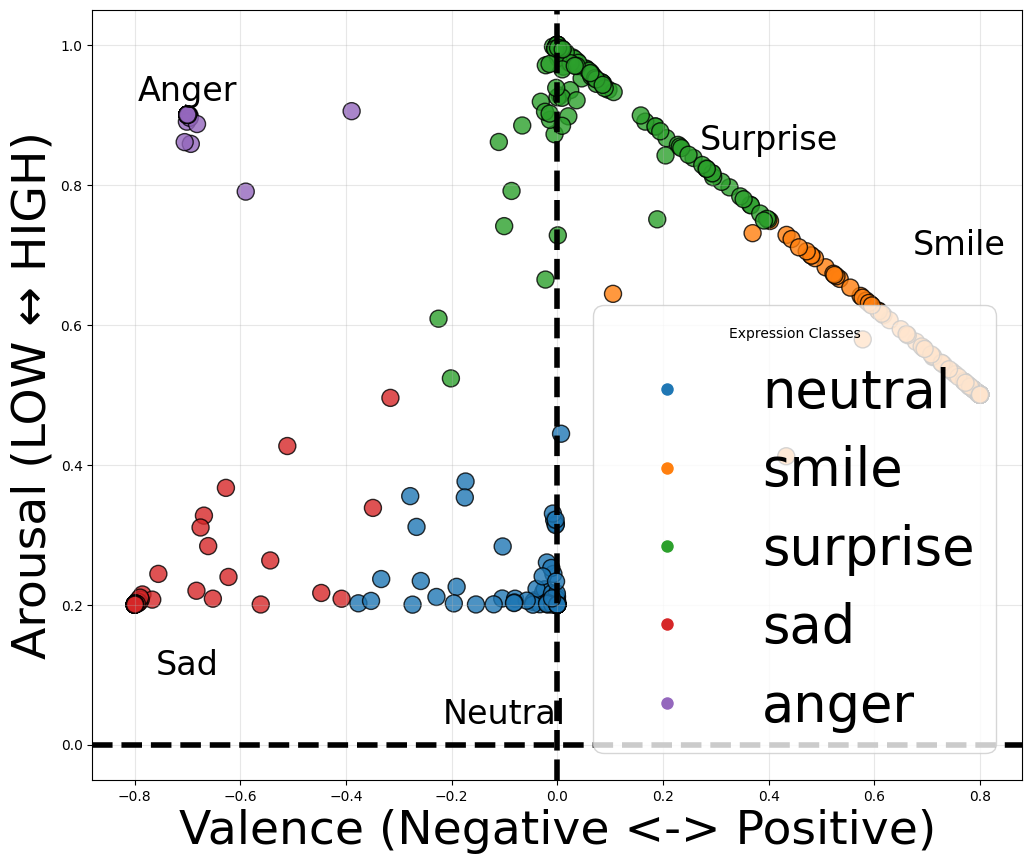

In [ ]:
custom_colors = plt.cm.tab10(range(len(class_labels)))

plt.figure(figsize=(12, 10))


scatter = plt.scatter(
    valence_values,  
    arousal_values, 
    c=[custom_colors[label] for label in all_preds],  
    alpha=0.8, 
    edgecolor='k',
    s=150 
)
# Annotations for quadrants
plt.text(0.76, 0.7, "Smile", fontsize=24,  ha='center')
plt.text(-0.7, 0.92, "Anger", fontsize=24, ha='center')
plt.text(-0.1, 0.03, "Neutral", fontsize=24,  ha='center')
plt.text(0.4, 0.85, "Surprise", fontsize=24,  ha='center')
plt.text(-0.7, 0.1, "Sad", fontsize=24, ha='center')

plt.axhline(0, color="black", linestyle="--", linewidth=4)
plt.axvline(0, color="black", linestyle="--", linewidth=4)
plt.grid(alpha=0.3)


plt.xlabel("Valence (Negative <-> Positive)", fontsize=34)
plt.ylabel("Arousal (LOW ↔ HIGH)", fontsize=34)


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=custom_colors[i], 
               markersize=10, 
               label=f"{expr}") 
    for i, expr in enumerate(class_labels)
]
plt.legend(handles=legend_elements, title="Expression Classes", fontsize=38, loc="lower right")

plt.show()

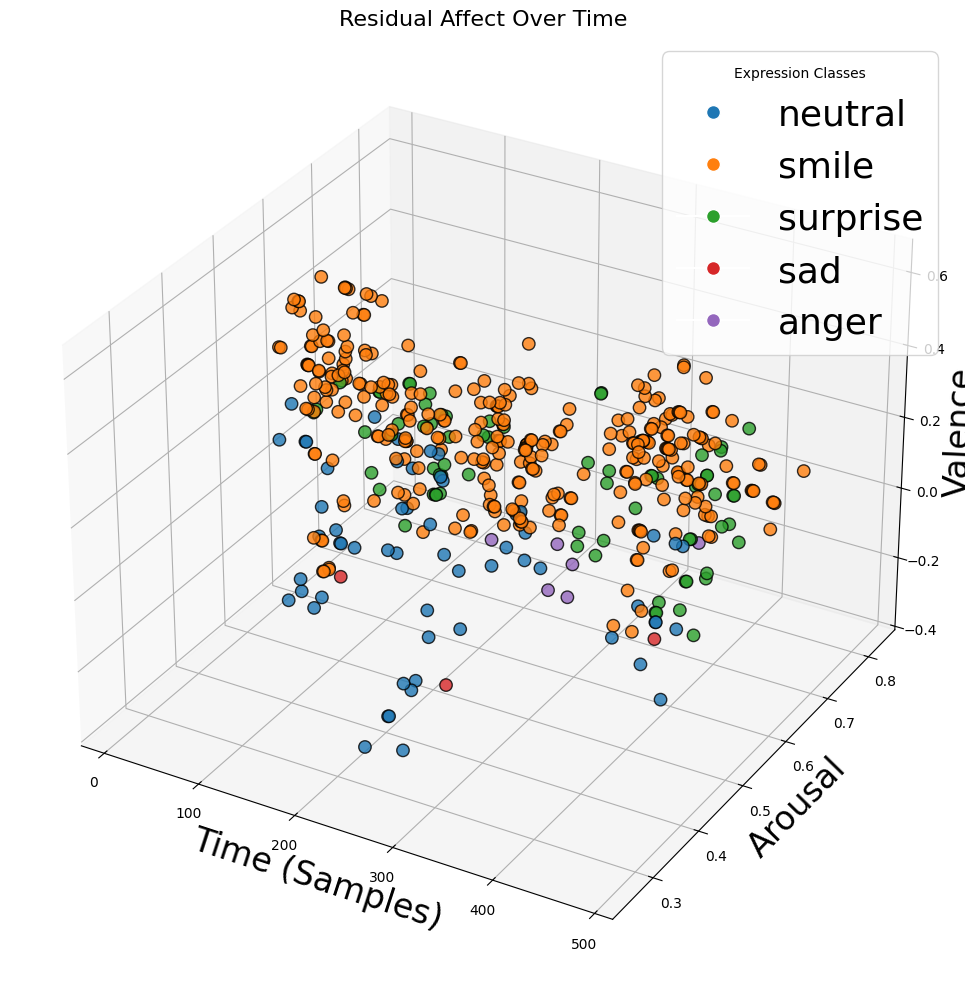

In [ ]:

window_size = 10

# Initialize lists to store smoothed values
smoothed_arousal = []
smoothed_valence = []
smoothed_classes = []


for i in range(window_size, len(arousal_values)):
    avg_arousal = np.mean(arousal_values[i - window_size:i])
    avg_valence = np.mean(valence_values[i - window_size:i])
    avg_class = np.argmax(np.bincount(all_preds[i - window_size:i]))  
    
    smoothed_arousal.append(avg_arousal)
    smoothed_valence.append(avg_valence)
    smoothed_classes.append(avg_class)

time_steps = range(window_size, len(arousal_values))  

# Create a 3D plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')


custom_colors = plt.cm.tab10(range(len(class_labels)))
scatter_colors = [custom_colors[label] for label in smoothed_classes]


sc = ax.scatter(
    time_steps, smoothed_arousal, smoothed_valence, 
    c=scatter_colors, alpha=0.8, edgecolor="k", s=80
)

ax.set_title("Residual Affect Over Time", fontsize=16)
ax.set_xlabel("Time (Samples)", fontsize=24)
ax.set_ylabel("Arousal", fontsize=24)
ax.set_zlabel("Valence", fontsize=24) 

plt.tight_layout()


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=custom_colors[i], 
               markersize=10, 
               label=f"{expr}") 
    for i, expr in enumerate(class_labels)
]
ax.legend(handles=legend_elements, title="Expression Classes", fontsize=26, loc="upper right")


plt.show()


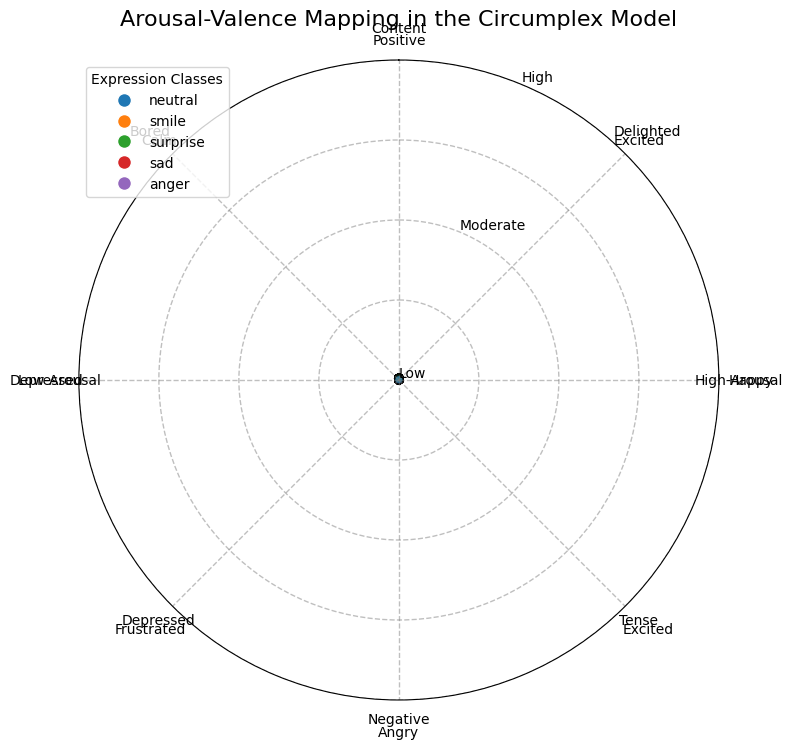

In [83]:
sample_size = 500
sample_indices = random.sample(range(len(all_preds)), min(sample_size, len(all_preds)))

sampled_arousal = [arousal_values[i] for i in sample_indices]
sampled_valence = [valence_values[i] for i in sample_indices]
sampled_labels = [all_preds[i] for i in sample_indices]

# Define a custom color map
custom_colors = plt.cm.tab10(range(len(class_labels)))

# Create a new figure with the desired aspect ratio
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

# Plot the data points on the polar plot
scatter = ax.scatter(
    np.deg2rad(sampled_valence), 
    sampled_arousal, 
    c=[custom_colors[label] for label in sampled_labels], 
    alpha=0.8, 
    edgecolor='k'
)

# Add grid lines
ax.grid(True, linewidth=1, color='gray', linestyle='--', alpha=0.5)

# Add the arousal and valence axes labels
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['Positive', 'Excited', 'High-Arousal', 'Tense', 'Negative', 'Depressed', 'Low-Arousal', 'Calm'])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_yticklabels(['Low', '', 'Moderate', '', 'High'])

# Add the emotion labels
ax.text(np.deg2rad(0), 220, 'Content', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(45), 220, 'Delighted', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(90), 220, 'Happy', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(135), 220, 'Excited', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(180), 220, 'Angry', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(225), 220, 'Frustrated', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(270), 220, 'Depressed', ha='center', va='center', fontsize=10)
ax.text(np.deg2rad(315), 220, 'Bored', ha='center', va='center', fontsize=10)

# Add a title
ax.set_title("Arousal-Valence Mapping in the Circumplex Model", fontsize=16)

# Create the legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=custom_colors[i], 
               markersize=10, 
               label=f"{expr}") 
    for i, expr in enumerate(class_labels)
]
ax.legend(handles=legend_elements, title="Expression Classes", fontsize=10, loc="upper left")

plt.show()

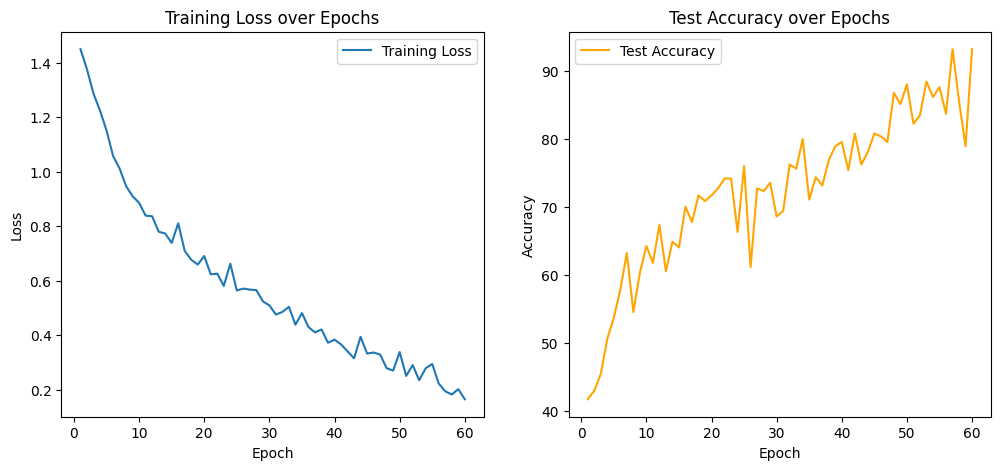

In [75]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 61), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plotting Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 61), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()

Test Accuracy: 0.9607


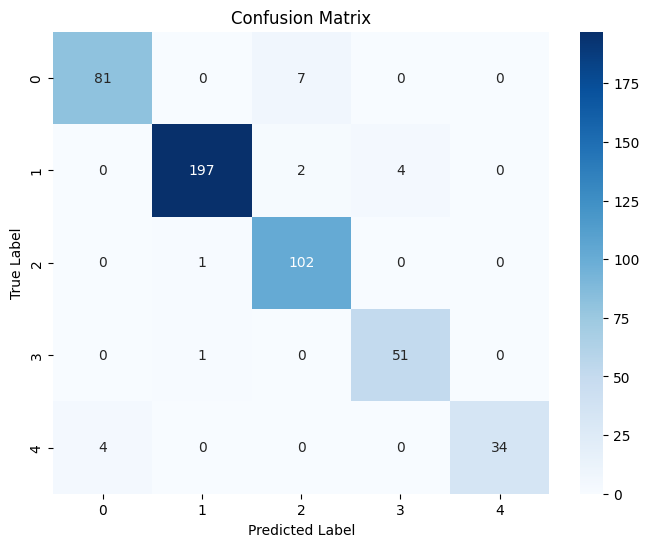

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        88
           1       0.99      0.97      0.98       203
           2       0.92      0.99      0.95       103
           3       0.93      0.98      0.95        52
           4       1.00      0.89      0.94        38

    accuracy                           0.96       484
   macro avg       0.96      0.95      0.95       484
weighted avg       0.96      0.96      0.96       484



In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for data, labels in test_loader:
        # Forward pass through the model
        outputs = model(data)
        
        # Get the predicted labels
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and labels for evaluation metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

In [ ]:
# Abbreviated class names
short_classes = [
    'Wink L', 'Wink R', 'L Eyebrow', 'R Eyebrow', 'Squint', 
    'Talk', 'Chew', 'Swallow', 'Smile', 'Frown', 'Puff Cheeks'
]

# Full forms for the caption
full_forms = [
    "Wink L: Winking of the left eye",
    "Wink R: Winking of the right eye",
    "L Eyebrow: Left eyebrow movement",
    "R Eyebrow: Right eyebrow movement",
    "Squint: Squinting of the eyes",
    "Talk: Talking",
    "Chew: Chewing",
    "Swallow: Swallowing",
    "Smile: Smiling",
    "Frown: Frowning",
    "Puff Cheeks: Puffing cheeks"
]

# Updated confusion matrix values
confusion_matrix = np.array([
    [73.93, 4.21, 0, 6.56, 1.47, 0, 0, 0, 10, 0, 3.83],
    [5.56, 82.22, 0, 0, 1.39, 0, 1.36, 4.78, 0, 2.13, 2.56],
    [0, 0, 89.64, 0, 0.94, 0, 9.35, 0.07, 0, 0, 0],
    [0, 0, 0, 88.33, 0, 0, 0, 7.22, 4.45, 0, 0],
    [3.18, 1.93, 0, 4.72, 78.06, 0.32, 4.18, 4.43, 3.18, 0, 0],
    [0, 0, 0, 0.39, 0, 92.16, 0.39, 0, 0, 1.95, 5.11],
    [0, 1.97, 10.36, 0, 1.18, 0, 84.72, 0, 0, 1.77, 0],
    [2.88, 4.04, 0, 0, 1.96, 0, 0, 63.8, 2.89, 11.62, 12.81],
    [1.49, 5.63, 0, 0, 1.49, 0, 0, 13.63, 77.76, 0, 0],
    [0, 0, 0, 0, 13.51, 0, 0, 0, 1.72, 68.33, 16.44],
    [12.96, 0, 0, 0, 0, 7.52, 0, 6.07, 0, 14.2, 59.25]
])

# Convert to DataFrame for plotting
df_cm = pd.DataFrame(confusion_matrix, index=short_classes, columns=short_classes)

# Plotting the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="Blues", cbar=True, annot_kws={"size": 20})

plt.xlabel('Predicted Class', fontweight='semibold', fontsize = 45)
plt.ylabel('True Class', fontweight='semibold', fontsize = 45)
plt.tight_layout()

# Display the full forms as a caption
caption = ""
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)

# Save and show the plot
plt.savefig("Confusion_Matrix.png", format='png', bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

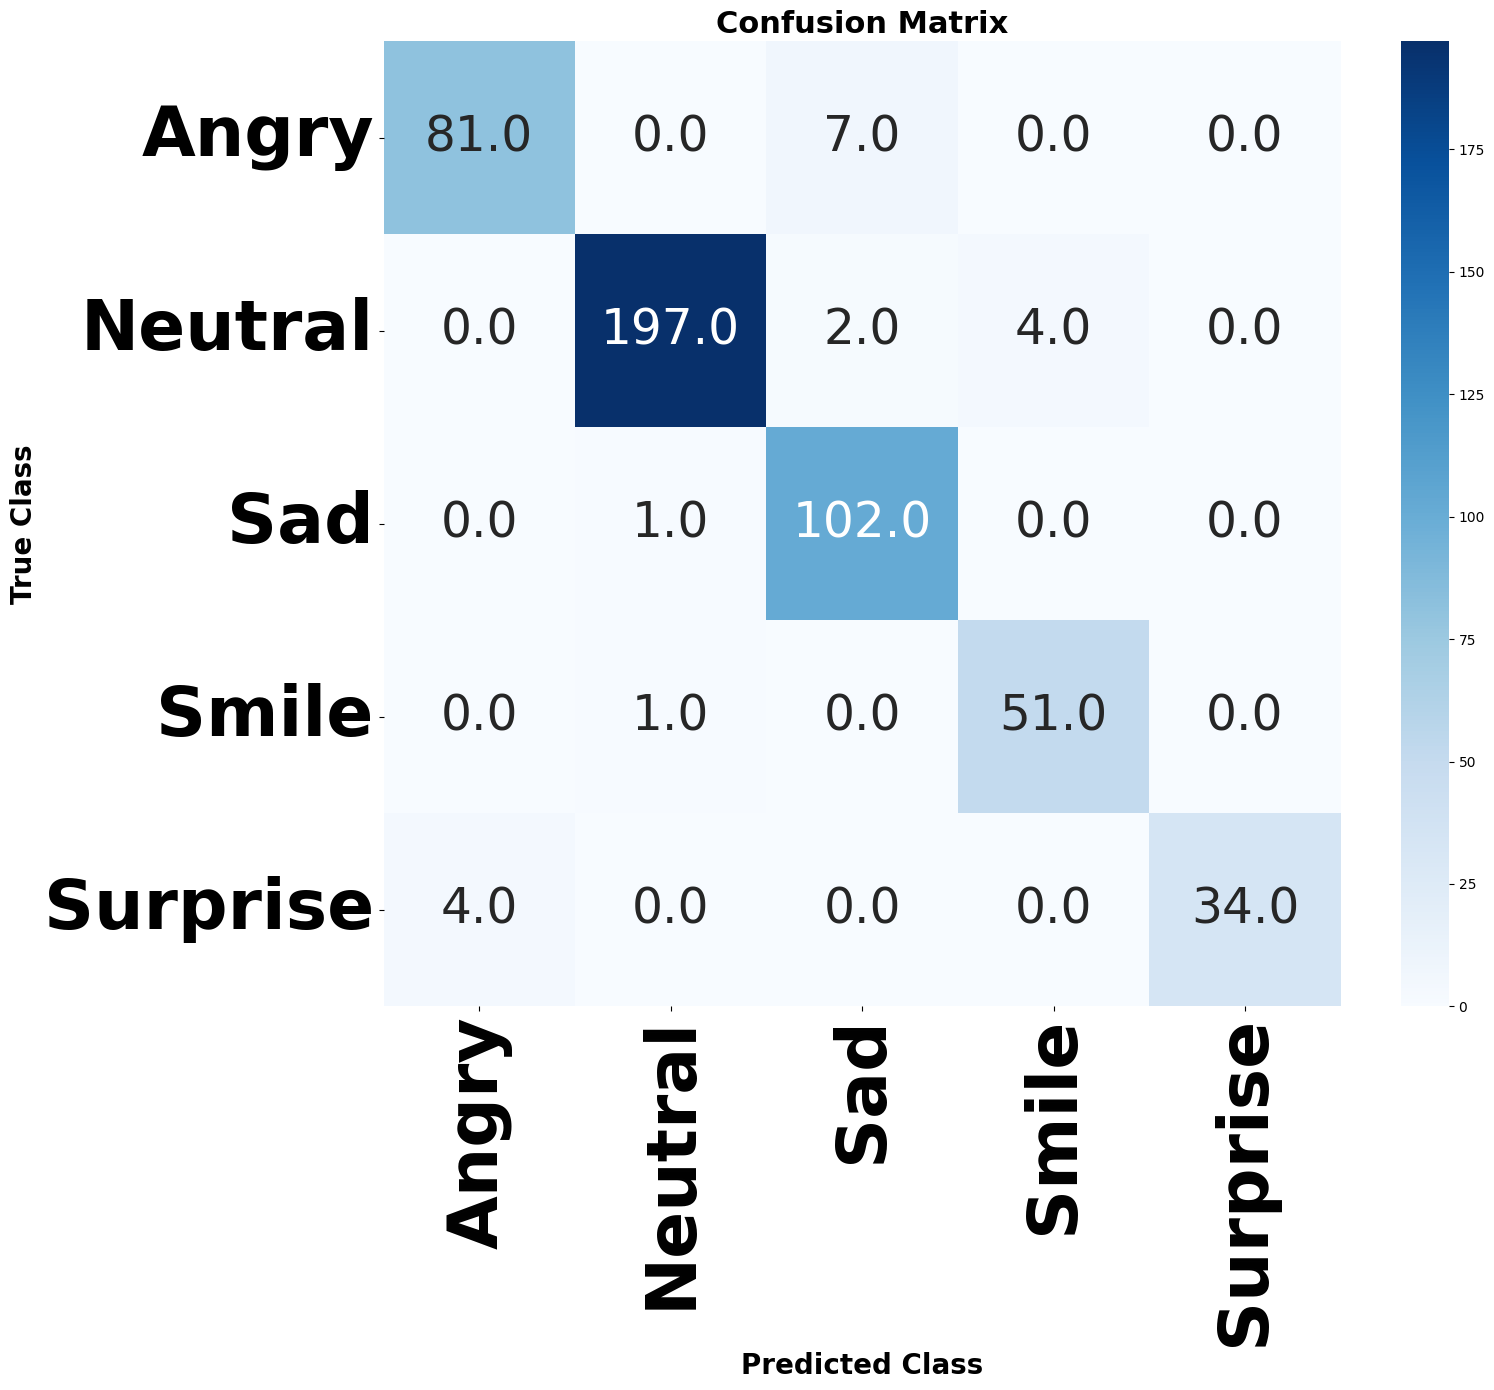

In [133]:

# Class names
short_classes = ['Angry', 'Neutral', 'Sad', 'Smile', 'Surprise']

# Updated confusion matrix values
confusion_matrix = np.array([
    [81, 0, 7, 0, 0],
    [0, 197, 2, 4, 0],
    [0, 1, 102, 0, 0],
    [0, 1, 0, 51, 0],
    [4, 0, 0, 0, 34]
])

# Convert to DataFrame for plotting
df_cm = pd.DataFrame(confusion_matrix, index=short_classes, columns=short_classes)

# Plotting the heatmap
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="Blues", cbar=True, annot_kws={"size": 35})

# Adjust font size for class labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=50,   rotation = 90 , fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=50, rotation  = 0 , fontweight='bold')

# Axis labels and title
plt.xlabel('Predicted Class', fontweight='semibold', fontsize=20)
plt.ylabel('True Class', fontweight='semibold', fontsize=20)
plt.title('Confusion Matrix', fontsize=22, fontweight='semibold')

plt.tight_layout()

# Save and show the plot
plt.savefig("Confusion_Matrix.png", format='png', bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

Actual: Surprise (Class 4), Predicted: Surprise (Class 4)
Actual: Angry (Class 0), Predicted: Angry (Class 0)
Actual: Smile (Class 3), Predicted: Smile (Class 3)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Angry (Class 0), Predicted: Angry (Class 0)
Actual: Surprise (Class 4), Predicted: Surprise (Class 4)
Actual: Angry (Class 0), Predicted: Angry (Class 0)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Surprise (Class 4), Predicted: Surprise (Class 4)
Actual: Angry (Class 0), Predicted: Angry (Class 0)
Actual: Smile (Class 3), Predicted: Nuutral (Class 1)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Nuutral (Class 1), Predicted: Nuutral (Class 1)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Nuutral (Class 1), Predicted: Nuutral (Class 1)
Actual: Sad (Class 2), Predicted: Sad (Class 2)
Actual: Smile (C

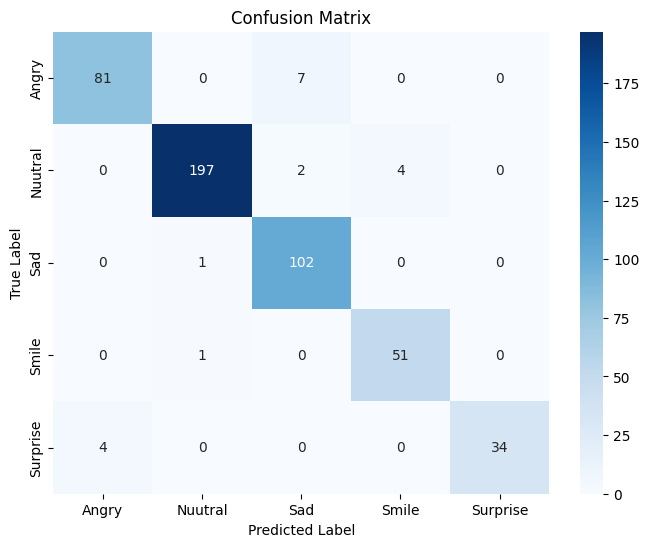


Classification Report:
              precision    recall  f1-score   support

       Angry       0.95      0.92      0.94        88
     Nuutral       0.99      0.97      0.98       203
         Sad       0.92      0.99      0.95       103
       Smile       0.93      0.98      0.95        52
    Surprise       1.00      0.89      0.94        38

    accuracy                           0.96       484
   macro avg       0.96      0.95      0.95       484
weighted avg       0.96      0.96      0.96       484



In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Define a dictionary mapping class indices to categorical names
class_names = {0: 'Angry', 1: 'Nuutral', 2: 'Sad', 3: 'Smile', 4: 'Surprise'}

# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for data, labels in test_loader:
        # Forward pass through the model
        outputs = model(data)
        
        # Get the predicted labels
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and labels for evaluation metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Print actual and predicted class names for each window
        for actual, predicted in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            actual_name = class_names[actual]
            predicted_name = class_names[predicted]
            print(f"Actual: {actual_name} (Class {actual}), Predicted: {predicted_name} (Class {predicted})")

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_names.values())))
